# The convolution for the mathematically mature reader

From the mathematical standpoint the convolution is a weird operation, not really beacuse of its definition, which is rather straight forward, but because it seems to pop up in seemingly unrealted contexsts, where it often acts as a deus ex machina to save the day.

A classical example is the Poisson equation on $\mathbb{R}^d$

$$\Delta u = f$$

which is elegantly solved by the function $u(x) = (f \ast G_d)(x)$, where $\Delta G_d = \delta_0$, the Dirac delta in zero. Another, perhaps more basic one, is the density of the sum of two independet random variables, which turns out to be the convolution of the two densities.

The idea is often that this operation smears one function onto the other, as nicely visualized in the <a url='https://en.wikipedia.org/wiki/Convolution'>wikipedia article</a>. What I always found more obscure is how an integral defined on the whole real line (or worse $\mathbb{R}^d$!) can turn out to be a useful tool in areas such as machine learning and image processing, where it can produce interesting resulsts such as this one.

<img src='images/Figure_1_convolution_ARROW.png' style='width: 1000px'>

This notebook aims to try and build a bridge between the abstract definition of the convolution and its nice mathematical properties, and the more practical uses in image processing and efficient implementations which in turn use some of those nice properties. The hope is that eventually this application oriented veiw will shine some intuition onto what the convolution really does.


## Step 1: from functions to vectors

The mathematical definition of convolution is the operation that takes two absolutely integrable functions $f,g$ and spits out a third integrable function $f \ast g$ according to the rule

$$(f \ast g)(x) = \int_{\mathbb{R}} f(x-y)g(y)dy$$

Broken down to more elementary operations this rule reflects the function $f$ around $0$, $f(y) \mapsto f(-y)$, translates it by $x$, $f(-y) \mapsto f(x-y)$, and computes the area under the two curve $f(x-y)$ scaled by $g(y)$.

Many domains are possible, namely $\ast : L^1(\mathbb{R}) \times L^p(\mathbb{R}) \rightarrow L^1(\mathbb{R})$, for any $p \geq 1$. However these domains are far away from being spaces of images, but a significant step in this direction is taken just by trying to implement this very operation on a computer.

In the following code I will approximate the integral above by evaluating it's Riemann sum

$$(f \ast g)(x) = \int_{\mathbb{R}} f(x-y)g(y)dy = \lim_{L \rightarrow \infty} \int_{-L}^L f(x-y)g(y)dy = 
\lim_{L \rightarrow \infty} \lim_{n \rightarrow \infty}
\frac{2L}{n} \sum_{k=-nL}^{nL} f\left (x-\frac kn \right)g\left(\frac kn \right)$$

and cutting the limit short at $n = 180$. Below $x$ is chosen in a grid of points lying in the interval $[-2,2]$, and we convolve the two functions 
$f(x) = e^{-x} \chi_{[-1,1]}(x)$ and
$g(x) = \chi_{[-1,1]}(x)$

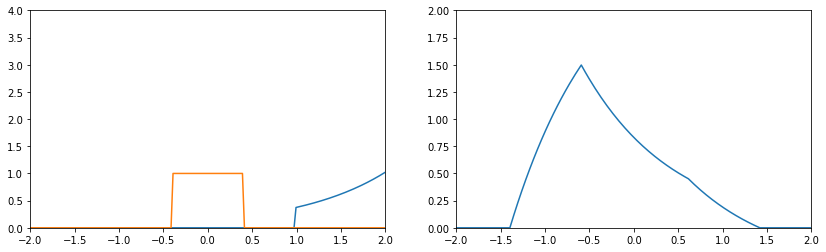

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

# defining grid
n = 180
L = 2
x = np.linspace(-L,L,n)

# defining functions f,g
def f (y):
    return np.array([np.exp(-k) if k>-1 and k<1 else 0. for k in y])

g = np.array([1. if k < 0.4 and k > -0.4 else 0. for k in x])

# setting up pyplot
fig, axs = plt.subplots(1,2, figsize=(14,4))
axs[0].set_xlim(-L,L)
axs[0].set_ylim(0,4)
axs[1].set_xlim(-L,L)
axs[1].set_ylim(0,2)

f_line, g_line = axs[0].plot([],[], [], [])
conv_line, = axs[1].plot([],[])

def init():
    f_line.set_data([],[])
    g_line.set_data([],[])
    
    conv_line.set_data([],[])
    return (f_line, g_line, conv_line)

# convolution function
convfg = np.zeros(x.shape)
def conv_step (i):
    tf = f(2 * L / n * i - L - x)
    convfg[i] = 2 * L / n * np.sum(tf * g)
    
    f_line.set_data(x, tf)
    g_line.set_data(x, g)
    conv_line.set_data(x, convfg)
    return (f_line, g_line, conv_line)

# plotting
anim = FuncAnimation(fig, conv_step, init_func=init, frames=n, interval=40, blit=True)
HTML(anim.to_html5_video())

To define the convolution for two vectors $f,g \in \mathbb{R}^n$ we could consider them as discretized versions of two functions evaluated on some grid of points and run the formula above. This definition though has some holes. apart from the fact that we should choose each time which $n$ is approporiate to cut the limit in the Riemann sum, when given two vectors we don't really know what functions they represent. 

In the example above $g$ is a numpy vector containing some ones in the middle and zeros at its ends. If we remove its ties with the grid $\{x_i\}_{i=1}^n$ it could represent any translated version of the same function. If for example we associated it to the grid $\{y_i\}_{i=1}^n$, where $y_i = x_i - 10$, then it'd represent the function $\tilde g(x) = \chi_{[9,11]}(x)$. This wouldn't really be a problem since the convolution is translation equivariant, but we wouldn't even know how spaced the grid points are and therefore how wide the rectangles of the Riemann sum would need to be. In other words the $L$ in the convolution formula should be decided arbitrarely every time. We would then have an infinite number of possible convolutions for each couple of vectors!

It turns out that some ideas from measure theory can be used to define the discrete convolution as an exact opretion, without needing to consider any approximations. Indeed for any measurable group $(G, \mathcal{A}, \mu)$ we can define the convolution as

$$(f \ast g)(x) = \int_G f(xy^{-1})g(y)d\mu(y)$$

where $y^{-1}$ is just the group invrse of $y$. So considering the group $(\mathbb{Z},+)$ with the counting measure $\#(A) = |A|$ for every $A \in \mathcal{P}(\mathbb{Z})$ we get

$$(f \ast g)(x) = \int_{\mathbb{Z}} f(x-y)g(y)d\#(y)$$

better known as the sum

$$(f \ast g)(i) = \sum_{j \in \mathbb{Z}} f(i-j)g(j)$$

where I've preferred to indicate $x$ with $i$ to emphasize its discrete nature.

This definition is almost what we want, except we'd like our input and output functions to have support on some finite subset of the positive integers, so that we can fully identify them with vectors. Moreover functions from $\mathbb{Z}$ can potentially have an infinite number of nonzero values, and no computer is able to sum an infinite amount of numbers in a finite amount of time.

To achieve this we limit our definition of discrete convolution to the functions on $f:\mathbb{Z} \rightarrow \mathbb{R}$ that have support on some set $\{0,...,n\}$ for some $n \in \mathbb{N}$. Therefore if supp$(f)=\{0,...,n\}$ and supp$(g)=\{0,...,m\}$ for some $n,m \in \mathbb{N}$ the coefficients in the sum above are different from zero iff the following conditions are satisfied

$$
    \left\{
        \begin{array}{ll}
            0 \leq i - j \leq n \; \; \; \; \; \text{for $f$ to be nonzero}\\
            0 \leq j \leq m \; \; \; \; \; \text{for $g$ to be nonzero}
        \end{array}
    \right.
$$

which is easily solved by $\max \{0,i-n\} \leq j \leq \min \{i,m\}$. This set of indices is not always non-empty.
If $i<0$ infact $\max \{0,i-n\} = 0$, but $\min \{i,m\} = i < 0$, and so we'd have to carry out the sum over the set $0 \leq j \leq i < 0$, in which every element is bigger and smaller than $0$ at the same time. This set clearly does not exist. A similar situation verifies when $i > n+m$.

In other words the $i$s for which the sum does not consist of all zeros are $0 \leq i \leq n+m$. Hence if we define the convolution of $f,g$ to be just the nonzero part of their convolution in $\mathbb{Z}$, we get that it is a vector in $\mathbb{R}^{n+m+1}$, which is just what we were after.

To sum up, to convolve two vectors $f \in \mathbb{R}^{n+1}$ and $g \in \mathbb{R}^{m+1}$:
1. extend them with zero values to functions $\bar f, \bar g$ on $\mathbb{Z}$
2. convolve $\bar f$ and $\bar g$ using integer convolution, producing $\overline{f \ast g}$
3. take $f \ast g$ to be $\overline{f \ast g}$ restricted to the set $\{0,...,n+m\}$

In practice we don't even need to extend $f,g$ to the whole set of integers, we can just keep them as vectors and quit summing when the above inequalities cease to hold, or extend them just enough, which we'll do in the next section.

This is all we need to implement the convolution. Here I treat the very special case in which $m = n$. To further simplify the code we can note that when $i<n$ we always have $\max \{0,i-n\} = 0$ and $\min \{i,n\} = i$, and while the converse is true when $i \geq n$. In my opinion this makes the code a bit more readable than having to include all those $\min$s and $\max$s.

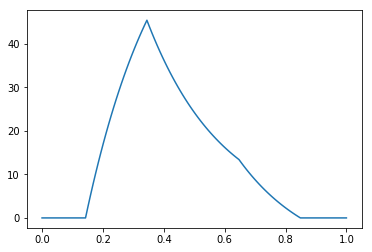

In [10]:
# redefining functions
n = 60
x = np.linspace(-1,1,n)
f = np.exp(-x)
g = np.array([1. if k < 0.4 and k > -0.4 else 0. for k in x])

# convolving
cx = np.linspace(0,1,2*n)
conv = np.zeros(2 * n)
for i in range(n):
    conv[i] = np.sum(f[i::-1] * g[:i+1])
    conv[n+i] = np.sum(f[:i:-1] * g[i+1:])
    
plt.plot(cx, conv)

Notice how the $y$ axis got taller from the previous convolution, since we're not multiplying the sum by $\frac{2L}{n}$ anymore. Moreover the grids $x$ and $cx$ are now just used to define the vectors and plotting, while they have no business in the convolution formula.

## Step 2: from sums to matrices

Looking back at the measure theoretic formulation, it's rather obvious that the convolution operator, essentially being an integral, is bilinear and symmetric. Indeed the sum

$$(f \ast g)(i) = \sum_{j \in \mathbb{Z}} f(i-j)g(j)$$

can be seen as a dot product. Fixing one function as 'the weight' or 'filter' and the other as 'the input' the convolution becomes a linear operator

$$\ast : L^1(\mathbb{Z}) \rightarrow L^1(\mathbb{Z})$$
 $$ f \longmapsto (f \ast w)$$
 
And if linear algebra ever taught us anything, is that any linear operator can be represented by a matrix. Its rows would be given by the coefficients of the dot product for every $i$, stacked as the functionals $\langle \tau_i w, \cdot \rangle$ where $\tau_i$ is the translation by $i$.

More precisely if like before we choose the filter $w$ to have $m$ entries and the input $f$ to have $n$, we know that the resulting function (or at this point, vector) will have $n+m$ nonzero entries. Therefore we can express the convolution as an $m+n \times n$ dimensional matrix, with its rows just being the coefficients $w_{i-j}$ of the sum above for every $i \in \{0,...,n+m\}$.

Computationally this approach is a bit wasteful, since the majority of these $w_{i-j}$ will have to be set to zero. Indeed for $i=1$ the supports of the two functions only cross in one place, namely $j = 1$, and the rest will have to be set to zero. This action corresponds to evaluating the filter $w$ in some spots outside of its support, and this is where the idea of sliding the filter above the function comes from.

$$
(f \ast w) = Wf = \begin{bmatrix}
    w_{0} & 0 & \cdots & \cdots & \cdots & 0 \\
    w_{1} & w_{0} & 0 & \cdots & \cdots & 0 \\
    \vdots & \ddots & & &  & \vdots\\
    w_{n-1}  & w_{n-2} & \cdots & \cdots & w_{0} & 0 \\
    w_{n} & w_{n-1} & \cdots & \cdots & \cdots & w_{0} \\
    0 & w_{n} & \cdots & \cdots & \cdots & w_{1} \\
    \vdots & & & & \ddots & \vdots \\
    0 & \cdots & \cdots & \cdots & 0 & w_{n}
\end{bmatrix}
\begin{bmatrix}
    f_0 \\
    f_1 \\
    \\
    \vdots \\
    f_n \\
    \vdots \\
    \\
    f_{n+m}
\end{bmatrix}
$$

In analogy with the sliding of the two functions we've seen before, here it is quite evident that what we did is just to reverse the weight components $w_i$ and slide them across the matrix, starting from the left towards the right, cutting the matrix when the weight disappears entirely. Matrices like these are called circulant, and, I kid you not, they actually form an algebra.

Here's the correspoding python code.

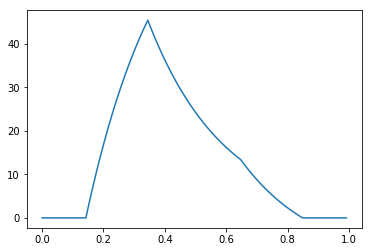

In [12]:
convmatz = np.zeros((2 * n - 1, n))
for i in range(2 * n - 1):
    for j in range(n):
        if (i <= n and j <= i) or (i > n and j  > i - n):
            convmatz[i,j] = g[n-i+j-1]
conv2 = np.dot(convmatz, f)

plt.plot(cx[:-1], conv2)

## Application to image smoothing and edge detection

This idea, virtually unchanged, is used in image denoising and compression. What if we have an image like the roses shown at the start of this notebook that looks rather pixelated, and we want to blur it so that this effect is less evident?

<img src='images/Figure_2_original_image.png' style='height: 300px;'>

A commonly adopted solution is given by applying (read convolving) a gaussian filter to the image, usually taken on the small area around $0$ where the output of the function $e^{-(x^2+y^2)/2}$ is not negligible. Typically this small area is organized in a grid of $5 \times 5$  pixels, or more rarely $9 \times 9$.

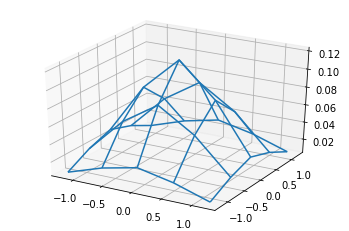

In [13]:
from mpl_toolkits.mplot3d import axes3d

# building a 5x5 gaussian weight
weight_size = 5
distx = np.linspace(-1.2, 1.2, weight_size)
X, Y = np.meshgrid(distx, distx)

weight = np.exp(-X*X-Y*Y)
weight = weight / np.sum(weight)

# plotting filter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, weight)

For the moment let's limit ourselves to black and white images, usually represented by a 2d-array having values in $[0,1]$ or $\{0,...,255\}$, depending on the format we're using. For our purposes we can think of them as functions from a grid in $\mathbb{Z}^2$ to the real numbers.

The idea is that by convolving this image with the gaussian filter it will become more homogenous, since every pixel will share the values of its neighbours, albeit less so the more we get far from it. This intuition is reminiscent of the convolution on the real domain, whose output inherits the regularity of the most regular of the two functions given as input. For instance, if $f$ isn't differentiable while $g \in C^1(\mathbb{R})$ then

$$\partial_x (f \ast g)(x) = \partial_x \int_{\mathbb{R}} f(y)g(x-y)dy =  \int_{\mathbb{R}} f(y)\partial_x g(x-y)dy
$$

where the last step is due to <a url='https://en.wikipedia.org/wiki/Dominated_convergence_theorem'>Lebesgue's dominated convergence theorem</a>. Hence $\partial_x (f \ast g)(x)$ is just $(f \ast g')(x)$.

While we could define the convolution for finite-support functions on $\mathbb{Z}^2$ the same way we did before in $\mathbb{Z}$ and find the indices for which the functions have nonzero values, this isn't really mathematically interesting and will make the code more complex. Here I've preferred to flatten every 2d-array involved and consider images as vectors, thus recycling the previous code and ideas.

In the following code four operations are performed:

1. I take a random image I found on the internet and downsample it taking one pixel every 6 in each direction
2. turn said image into black and white by mixing the 3 RGB channels in the right proportions
3. add a 4 pixel wide frame around the image
4. flatten the image to make it into a vector

Step three is called padding, and it's commonly used to deal with borders when applying convolutions. When the weight reaches the edge of the image infact we have three choices:

1. wrap it around the image and make it come out the other side. This idea is from circular convolution, which is just the convolution defined on the circle group. In our case though this is undesirable since it means that the pixels near the edge will share values with the pixels on the opposite side.
2. cutting the weight
3. padding the image up to the point in which the supports of the weight and the image are disjoint.

Options 2 and 3 are both ok in our case, but I'll go ahead and choose option three since it's more consistent with the previous functional approach.

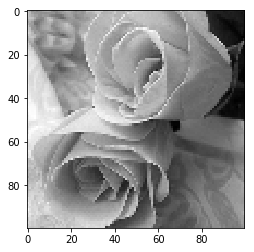

In [14]:
from matplotlib import image as mpimg

# importing and downsampling
image = mpimg.imread('images/Beautiful-Pink-Rose.jpg')[::6,::6]

# turning to grayscale
r,g,b = image[:,:,0], image[:,:,1], image[:,:,2]
gray_image = 0.299 * r + 0.587 * g + 0.114 * b

plt.imshow(gray_image, cmap=plt.get_cmap('gray'))

In [15]:
# padding
image_padding = ((weight_size - 1, weight_size - 1), (weight_size - 1, weight_size - 1))
flat_image = np.pad(gray_image, image_padding, 'constant')

# flattening
image_size = flat_image.shape[0]
flat_image = flat_image.flatten()

We can conveniently use numpy's pad function to make the weight matrix. The weight is currently a $5 \times 5$ array, while the padded image is much larger. We need a matrix of size $\texttt{image_size} \times \texttt{image_size}$.

Since we already did build a circulant matrix from scratch, we'll let scipy's linear algebra package do the hard work for us this time around.

In [16]:
# padding and flattening weight
weight_padding = (
    (0, image_size - weight_size), 
    (0, image_size - weight_size)
) 
flat_weight = np.pad(weight, weight_padding, 'constant').flatten()

# building circulant matrix
from scipy import linalg
image_conv_mat = linalg.circulant(flat_weight)

And that's it, now blurring the image is as simple as doing a dot product.

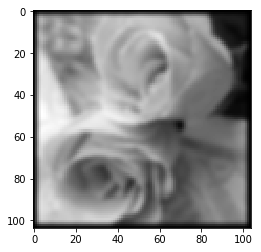

In [17]:
# convolving
blurred_image = np.dot(image_conv_mat, flat_image)

# reshaping and plotting
blurred_image = np.reshape(blurred_image, (image_size, image_size))[4:,4:]
plt.imshow(blurred_image, cmap=plt.get_cmap('gray'))

The picture you saw at the start of this notebook was produced by code quite like the one written above. I just convolved the three RGB channels separately.

It's evident that this is just a paricular example of what we can do by convolving a specific filter with an image. Another common application, which shows just how much the result depends on the filter, is edge detection. I will not go  into details of how this tecnique is effective, but the idea is that the $3 \times 3$ matrix below highlights the difference between the central pixel and the surrounding ones by changing their sign and amplifiying their difference by a relatively large amount.

$$ E = \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 8 & -1 \\
    -1 & -1 & -1
\end{bmatrix}
$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


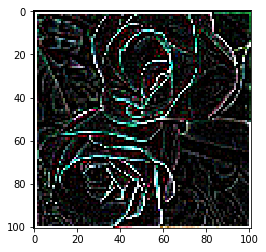

In [18]:
# bulding filter
weight_size = 3
edge_weight = -np.ones((weight_size, weight_size))
edge_weight[1,1] = 8

# padding and flattening image
image_padding = ((weight_size - 1, weight_size - 1), (weight_size - 1, weight_size - 1), (0,0))
flat_image = np.pad(image, image_padding, 'constant')
image_size = flat_image.shape[0]
flat_image = np.transpose(flat_image, (2, 0, 1)).reshape(3, image_size ** 2)

# padding and flatteining filter
weight_padding = (
    (0, image_size - weight_size), 
    (0, image_size - weight_size)
) 
flat_weight = np.pad(edge_weight, weight_padding, 'constant')

# building circulant matrix
image_conv_mat = linalg.circulant(flat_weight)

# convolving
final_image = []
for k in range(3):
    result = np.dot(flat_image[k], image_conv_mat)
    result = np.reshape(result, (image_size, image_size))[:-weight_size, :-weight_size]
    final_image.append(result)

# making RGB image
result = np.transpose(np.stack(final_image), (1,2,0)) / 255

# showing result
plt.imshow(result)
plt.show()

From this we can call an edge any pixel with a value above a number of our choice in $[0,1]$. Of course in general you'd have to be very clever to come up with a filter that actually does something useful when convolved.

A popular design of neural network layers, which in 2011 sparked the current AI revolution, is the convolutional neural network. One layer of such a network does nothing but apply a convolution with a filter of predetermined size, except this time the filter coefficients are not speecified by some clever human, but learned through a statistical optimization algorithm. In simple terms the network is left to learn by itself what's the best convolution for its purposes!

## Improving speed

If you executed the code above live you'll have noticed that some parts take some seconds to complete. As I touched on before this way of performing the convolution is quite slow. When we were dealing with simple vectors in section 1, this wasn't really an issue, but with images it becomes an important factor. Just imagine having to convolve a full HD image, you'd have to build a matrix $(1920 \cdot 1080) \times (1920 \cdot 1080)$, that's more than $4 \cdot 10^{12}$ floating point numbers!

TBC: FFT